# 🔥FLAME🔥

* Download FLAME model from [here](http://flame.is.tue.mpg.de/). You need to sign up and agree to the model license for access to the model. Copy the downloaded model inside the **flame/model** folder. 
* Download Landmark embedings from [RingNet Project](https://github.com/soubhiksanyal/RingNet/tree/master/flame_model). Copy it inside the **flame/model** folder. 

In [1]:
from dataclasses import dataclass
from flame.flame_pytorch import FLAME
import matplotlib.pyplot as plt
import numpy as np
import torch
import trimesh
import pyrender
import os

In [2]:
@dataclass
class FLAMEConfig:
    flame_model_path: str = "./flame/model/generic_model.pkl"
    static_landmark_embedding_path: str = "./flame/model/flame_static_embedding.pkl"
    dynamic_landmark_embedding_path: str = "./flame/model/flame_dynamic_embedding.npy"
    shape_params: int = 100
    expression_params: int = 50
    pose_params: int = 6
    use_face_contour: bool = True
    use_3D_translation: bool = True
    optimize_eyeballpose: bool = True
    optimize_neckpose: bool = True
    num_worker: int = 4
    batch_size: int = 1
    ring_margin: float = 0.5
    ring_loss_weight: float = 1.0

In [3]:
flamelayer = FLAME(FLAMEConfig())

creating the FLAME Decoder


In [4]:
pose_params = torch.zeros(1, 6)

generated_vertices = []
for i in range(3):
    shape_params = torch.randn(1, 100)
    expression_params = torch.randn(1, 50)
    
    vertices, landmark = flamelayer(shape_params, expression_params, pose_params)
    generated_vertices.append(vertices)

In [5]:
os.environ["PYOPENGL_PLATFORM"] = "egl"  # For headless rendering

def render(vertices, faces, image_size=(800, 800)):
    vertices = vertices[0].cpu().numpy()

    # ---- Build mesh ----
    mesh = trimesh.Trimesh(vertices=vertices,
                           faces=faces,
                           process=False)
    pm = pyrender.Mesh.from_trimesh(mesh, smooth=True)

    # ---- Scene ----
    scene = pyrender.Scene(bg_color=np.zeros(4))
    # Add mesh
    scene.add(pm)
    
    # ---- Auto center ----
    center = mesh.bounds.mean(axis=0)
    extents = mesh.extents
    radius = np.linalg.norm(extents) * 0.5

    # ---- Camera ----
    camera = pyrender.PerspectiveCamera(yfov=np.deg2rad(45.0))
    scene.add(
        camera,
        pose=np.array([
            [1, 0, 0, center[0]],
            [0, 1, 0, center[1]],
            [0, 0, 1, center[2] + 2.5 * radius],
            [0, 0, 0, 1],
        ])
    )

    # ---- Light (simple directional) ----
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
    scene.add(
        light,
        pose=np.array([
            [1, 0, 0, center[0]],
            [0, 1, 0, center[1] + radius],
            [0, 0, 1, center[2] + radius],
            [0, 0, 0, 1],
        ])
    )

    # ---- Render ----
    w, h = image_size
    r = pyrender.OffscreenRenderer(w, h)
    color, _ = r.render(scene)
    r.delete()

    return color


def visualize_img(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

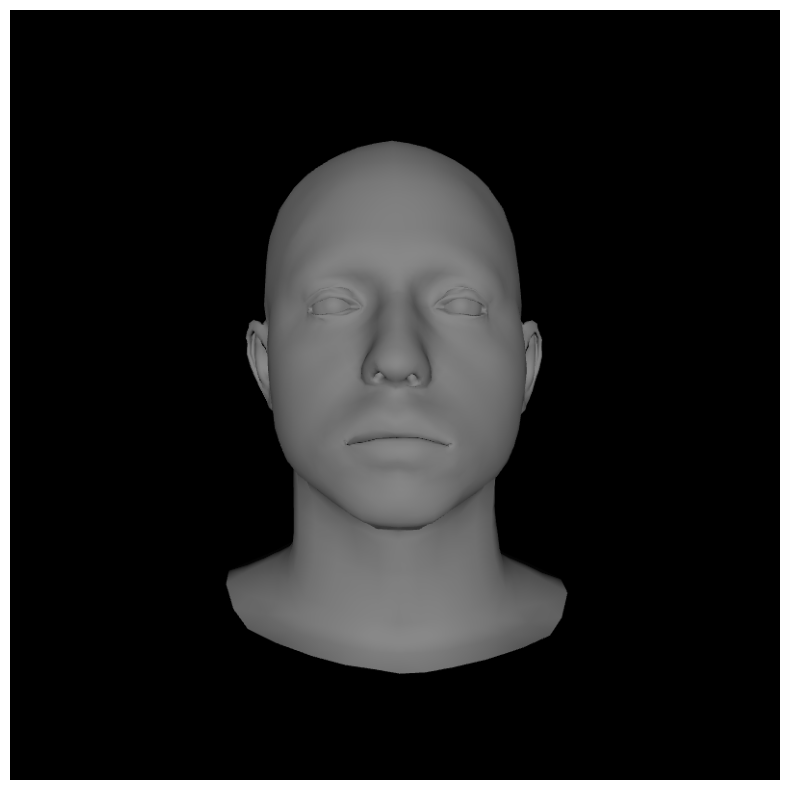

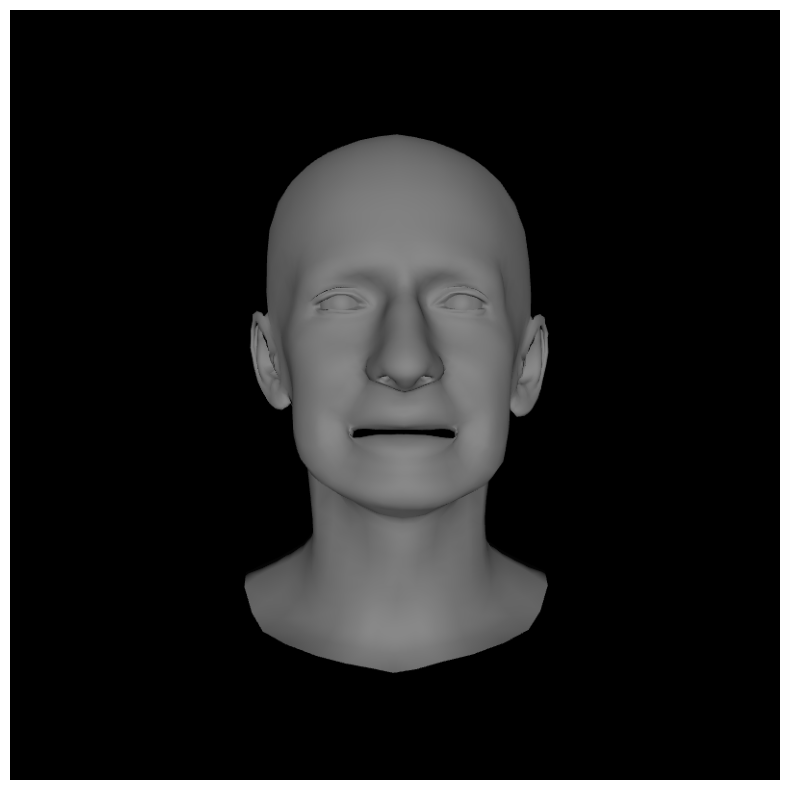

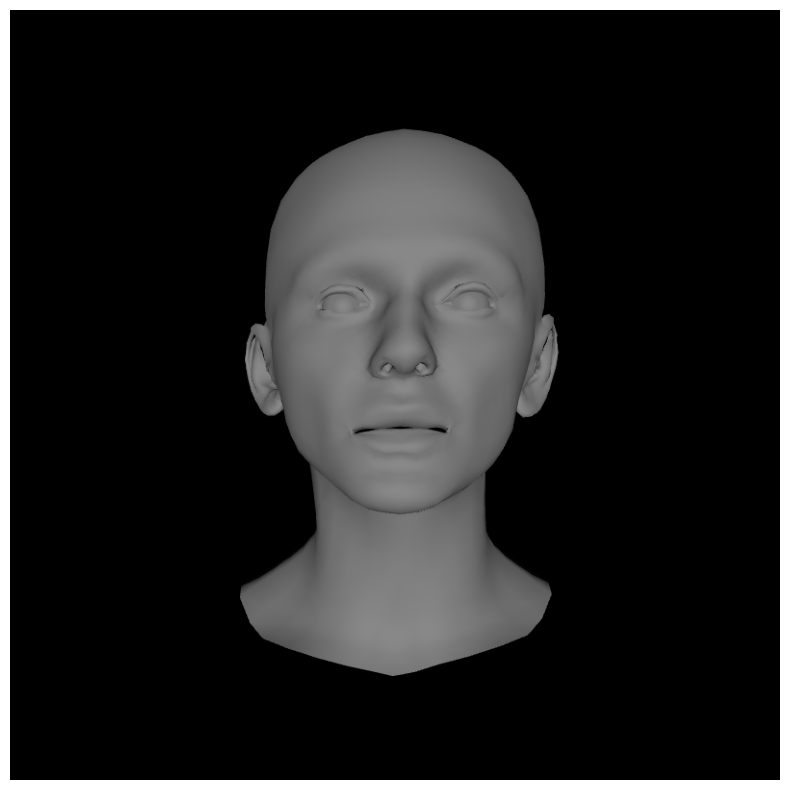

In [6]:
for vertices in generated_vertices:
    img = render(vertices, flamelayer.faces)
    visualize_img(img)